## 

In [4]:
import os
import argparse
from os.path import join as pjoin
import copy
import sys
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
from scipy import sparse

import warnings 
import sys 

# sys.path.append("../../argoverse-api/") 
# sys.path.append("../Utils/")

# import torch
from torch.utils.data import Dataset, DataLoader

from argoverse.data_loading.argoverse_forecasting_loader import ArgoverseForecastingLoader
from argoverse.map_representation.map_api import ArgoverseMap
from argoverse.visualization.visualize_sequences import viz_sequence
from argoverse.utils.mpl_plotting_utils import visualize_centerline 

# from core.util.preprocessor.base import Preprocessor
# from core.util.cubic_spline import Spline2D  



ModuleNotFoundError: No module named 'Dataset'

### CubicSpline 
For TNT Target Candidate Sampling Process

In [5]:
"""
Cubic spline planner
Author: Atsushi Sakai(@Atsushi_twi)
Source: https://github.com/AtsushiSakai/PythonRobotics/blob/master/PathPlanning/CubicSpline/cubic_spline_planner.py
"""
import math
import numpy as np
import bisect


class Spline:
    """
    Cubic Spline class
    """

    def __init__(self, x, y):
        self.b, self.c, self.d, self.w = [], [], [], []

        self.x = np.array(x)
        self.y = np.array(y)

        self.eps = np.finfo(float).eps

        self.nx = len(x)  # dimension of x
        h = np.diff(x)

        # calc coefficient c
        self.a = np.array([iy for iy in y])

        # calc coefficient c
        A = self.__calc_A(h)
        B = self.__calc_B(h)
        self.c = np.linalg.solve(A, B)
        #  print(self.c1)

        # calc spline coefficient b and d
        for i in range(self.nx - 1):
            self.d.append((self.c[i + 1] - self.c[i]) / (3.0 * h[i] + self.eps))
            tb = (self.a[i + 1] - self.a[i]) / (h[i] + self.eps) - h[i] * \
                (self.c[i + 1] + 2.0 * self.c[i]) / 3.0
            self.b.append(tb)
        self.b = np.array(self.b)
        self.d = np.array(self.d)

    def calc(self, t):
        """ 
        -- t = s 
        Calc position
        if t is outside of the input x, return None
        """
        t = np.asarray(t)
        mask = np.logical_and(t < self.x[0], t > self.x[-1])
        t[mask] = self.x[0]

        i = self.__search_index(t)
        dx = t - self.x[i.astype(int)]
        result = self.a[i] + self.b[i] * dx + \
            self.c[i] * dx ** 2.0 + self.d[i] * dx ** 3.0

        result = np.asarray(result)
        result[mask] = None
        return result

    def calcd(self, t):
        """
        Calc first derivative
        if t is outside of the input x, return None
        """
        t = np.asarray(t)
        mask = np.logical_and(t < self.x[0], t > self.x[-1])
        t[mask] = 0

        i = self.__search_index(t)
        dx = t - self.x[i]
        result = self.b[i] + 2.0 * self.c[i] * dx + 3.0 * self.d[i] * dx ** 2.0

        result = np.asarray(result)
        result[mask] = None
        return result

    def calcdd(self, t):
        """
        Calc second derivative
        """
        t = np.asarray(t)
        mask = np.logical_and(t < self.x[0], t > self.x[-1])
        t[mask] = 0

        i = self.__search_index(t)
        dx = t - self.x[i]
        result = 2.0 * self.c[i] + 6.0 * self.d[i] * dx

        result = np.asarray(result)
        result[mask] = None
        return result

    def __search_index(self, x):
        """
        search data segment index
        """
        indices = np.asarray(np.searchsorted(self.x, x, "left") - 1)
        indices[indices <= 0] = 0
        return indices

    def __calc_A(self, h):
        """
        calc matrix A for spline coefficient c
        """
        A = np.zeros((self.nx, self.nx))
        A[0, 0] = 1.0
        for i in range(self.nx - 1):
            if i != (self.nx - 2):
                A[i + 1, i + 1] = 2.0 * (h[i] + h[i + 1])
            A[i + 1, i] = h[i]
            A[i, i + 1] = h[i]

        A[0, 1] = 0.0
        A[self.nx - 1, self.nx - 2] = 0.0
        A[self.nx - 1, self.nx - 1] = 1.0
        #  print(A)
        return A

    def __calc_B(self, h):
        """
        calc matrix B for spline coefficient c
        """
        B = np.zeros(self.nx)
        for i in range(self.nx - 2):
            B[i + 1] = 3.0 * (self.a[i + 2] - self.a[i + 1]) / (h[i + 1] + self.eps) \
                       - 3.0 * (self.a[i + 1] - self.a[i]) / (h[i] + self.eps)
        return B


class Spline2D:
    """
    2D Cubic Spline class
    """

    def __init__(self, x, y, resolution=0.1):
        self.s = self.__calc_s(x, y) 
        
        # S-X
        self.sx = Spline(self.s, x) 
        
        # S-Y 
        self.sy = Spline(self.s, y)

        self.s_fine = np.arange(0, self.s[-1], resolution)
        xy = np.array([self.calc_global_position_online(s_i) for s_i in self.s_fine])

        self.x_fine = xy[:, 0]
        self.y_fine = xy[:, 1]

    # 计算s值
    def __calc_s(self, x, y):
        # 计算x，y的差值
        dx = np.diff(x)
        dy = np.diff(y)
        # 计算s值
        self.ds = np.hypot(dx, dy)
        # 初始化s值
        s = [0]
        # 计算s值
        s.extend(np.cumsum(self.ds))
        # 返回s值
        return s

    def calc_global_position_online(self, s):
        """
        calc global position of points on the line, s: float
        return: x: float; y: float; the global coordinate of given s on the spline
        """
        x = self.sx.calc(s)
        y = self.sy.calc(s)

        return x, y

    def calc_global_position_offline(self, s, d):
        """
        calc global position of points in the frenet coordinate w.r.t. the line.
        s: float, longitudinal; d: float, lateral;
        return: x, float; y, float;
        """
        s_x = self.sx.calc(s)
        s_y = self.sy.calc(s)

        theta = math.atan2(self.sy.calcd(s), self.sx.calcd(s))
        x = s_x - math.sin(theta) * d
        y = s_y + math.cos(theta) * d
        return x, y

    def calc_frenet_position(self, x, y):
        """
        cal the frenet position of given global coordinate (x, y)
        return s: the longitudinal; d: the lateral
        """
        # find nearst x, y
        diff = np.hypot(self.x_fine - x, self.y_fine - y)
        idx = np.argmin(diff)
        [x_s, y_s] = self.x_fine[idx], self.y_fine[idx]
        s = self.s_fine[idx]

        # compute theta
        theta = math.atan2(self.sy.calcd(s), self.sx.calcd(s))
        d_x, d_y = x - x_s, y - y_s
        cross_rd_nd = math.cos(theta) * d_y - math.sin(theta) * d_x
        d = math.copysign(np.hypot(d_x, d_y), cross_rd_nd)
        return s, d

    def calc_curvature(self, s):
        """
        calc curvature 
        曲率公式  k = (ddy*dx - ddx*dy)/(dx^2+dy^2)^(3/2)
        """
        dx = self.sx.calcd(s)
        ddx = self.sx.calcdd(s)
        dy = self.sy.calcd(s)
        ddy = self.sy.calcdd(s)
        k = (ddy * dx - ddx * dy) / ((dx ** 2 + dy ** 2)**(3 / 2))
        return k

    def calc_yaw(self, s):
        """
        calc yaw
        """
        dx = self.sx.calcd(s)
        dy = self.sy.calcd(s)
        yaw = np.arctan2(dy, dx)
        return yaw


def calc_spline_course(x, y, ds=0.1):
    sp = Spline2D(x, y)
    s = list(np.arange(0, sp.s[-1], ds))

    rx, ry, ryaw, rk = [], [], [], []
    for i_s in s:
        ix, iy = sp.calc_global_position_online(i_s)
        rx.append(ix)
        ry.append(iy)
        ryaw.append(sp.calc_yaw(i_s))
        rk.append(sp.calc_curvature(i_s))

    return rx, ry, ryaw, rk, s


def main():  # pragma: no cover
    print("Spline 2D test")
    import matplotlib.pyplot as plt
    # x = [-2.5, 0.0, 2.5, 5.0, 7.5, 3.0, -1.0]
    # y = [0.7, -6, 5, 6.5, 0.0, 5.0, -2.0]
    x = [float(i) for i in range(30)]
    y = [float(0.0) for i in range(30)]
    for i in range(len(y)):
        if i % 2 == 0.0:
            y[i] = float(i)

    ds = 0.1  # [m] distance of each intepolated points

    sp = Spline2D(x, y)
    s = np.arange(0, sp.s[-1], ds)

    rx, ry, ryaw, rk = [], [], [], []
    rx, ry = sp.calc_global_position_online(s)
    ryaw = sp.calc_yaw(s)
    rk = sp.calc_curvature(s)

    plt.subplots(1)
    plt.plot(x, y, "xb", label="input")
    plt.plot(rx, ry, "-r", label="spline")
    plt.grid(True)
    plt.axis("equal")
    plt.xlabel("x[m]")
    plt.ylabel("y[m]")
    plt.legend()

    plt.subplots(1)
    plt.plot(s, [np.rad2deg(iyaw) for iyaw in ryaw], "-r", label="yaw")
    plt.grid(True)
    plt.legend()
    plt.xlabel("line length[m]")
    plt.ylabel("yaw angle[deg]")

    plt.subplots(1)
    plt.plot(s, rk, "-r", label="curvature")
    plt.grid(True)
    plt.legend()
    plt.xlabel("line length[m]")
    plt.ylabel("curvature [1/m]")

    plt.show()


# if __name__ == '__main__':
#     main()

### Argoverse数据处理

In [103]:
class ArgoversePreprocessor(Dataset): 
    """ 
    original datatree
        - TNT-Traj-Pred 
            - dataset 
                - raw_data 
                    - train 
                        - .csv 
                    - val 
                        - .csv 
                    - test_obs 
                        - .csv 
                - interm_data (2D) 
    
    realistic datatree 
        - TNT-Trajectory-Predicition 
            - train
                - train 
                    - data 
                        - .csv 
            - test 
                - test_obs
                    - data
                        - .csv 
            - val 
                - val 
                    - data 
                        - .csv  
            - interm_data 
    """
    
    def __init__(self, 
                 root_dir, 
                 split="train",  # test/val/train
                 algo="tnt",
                 obs_horizon = 20, # 20 * 0.1 = 2s 观测 
                 obs_range = 100, # -50 ~ 50 
                 pred_horizon = 30, # 预测 30 * 0.1 = 2s 
                 normalized = True, 
                 save_dir = None 
                 ):
        super().__init__() 
        
        # LANE_WIDTH   & COLOR_DICT 固有属性 
        self.LANE_WIDTH = {'MIA': 3.84, 'PIT': 3.97}
        self.COLOR_DICT = {"AGENT": "#d33e4c", "OTHERS": "#d3e8ef", "AV": "#007672"} 
        
        # ---- init params ----
        self.root_dir = root_dir
        self.algo = algo 
        self.obs_horizon = obs_horizon 
        self.obs_range = obs_range 
        self.pred_horizon = pred_horizon
        
        self.split = split
        self.normalized = normalized  
        
        # MAP初始化 
        self.am = ArgoverseMap() 
        
        # 'test_obs' or 'train' or 'val'  
        self.loader_dir = pjoin(self.root_dir,split) # /train/ 
        self.loader_dir = pjoin(self.loader_dir, self.split+"_obs"+"/data" if self.split == "test" else self.split+"/data") 
        
        assert os.path.exists(self.loader_dir), "【Warning!】data path error ... "
        self.loader = ArgoverseForecastingLoader(self.loader_dir)
        # self.loader = ArgoverseForecastingLoader(pjoin(self.root_dir, self.split+"_obs" if split == "test" else split)) # pjoin == os.path.join 
        
        # 保存路径
        self.save_dir = save_dir 
        print("数据预处理器实例化成功") # debug  
        
        
        
    
    def __getitem__(self, idx): 
        """Key-Value"""
        pass 
    
    
    # Main function of preprocess 
    def process(self, dataframe:pd.DataFrame, seq_id, map_feat = True): 
        """
        dataframe : data frame 
        seq_id: sequence id 
        map_feat : 地图特征数据   
        
        return: 
            DataFrame (处理后数据)
        """
        # 数据预处理  
        # 输出: 
            # data: dict() 
                # key1 = city 
                # key2 = trajs (AV\AGENTS\OTHERS的轨迹)
                # key3 = steps (AV\AGENTS\OTHERS的时间步)
        data = self.read_argo_data(dataframe) 
        
        # features 
        data = self.get_obj_feats() 
        
        # graphs  
        
        
        # seq_id 
        
        return  None 
        
        
    def process_and_save(self, dataframe:pd.DataFrame, seq_id, dir_=None, map_feat = True):
        """预处理 & 保存

        Args:
            dataframe (pd.DataFrame): data frame 
            seq_id (str): seq_id
            dir_ : the dir 保存.csv 
            map_feat :  bool 是否输出map feature
        """ 
        df_processed = self.process() #TODO  
        # 保存 
        self.save(df_processed, seq_id, dir_)  
        
        return []
         
    
    def __len__(self):
        return len(self.loader)  
    
    @staticmethod
    def read_argo_data(df: pd.DataFrame):  # DONE 
        """argoverse数据读取
        - 读取的是一个pd.DataFrame, 比如 data/1.csv  
        
        Returns:
            data dict() ['city', 'trajs', 'steps']
        """
        city = df["CITY_NAME"].values[0] 
        # print(city)  
        
        # TIMESTAMP|TRACK_ID|OBJECT_TYPE(AD,AGENT,OTHERS)|X,Y|CITY_NAME
        # 去重，并将其排序  
        after_deduplicate = np.unique(df['TIMESTAMP'].values)
        agt_ts = np.sort(after_deduplicate)   
        
        mapping = dict() 
        for i, ts in enumerate(agt_ts): 
            mapping[ts] = i # 地图时间错与索引mapping
        
        # trajs 
        traj_x = df.X.to_numpy().reshape(-1,1) 
        traj_y = df.Y.to_numpy().reshape(-1,1) 
        trajs = np.concatenate((traj_x, traj_y), 1) # (len,2)  
        
        # timesteps 
        # len = len(df) e.g. 339 
        # 数值 [0~49] 代表50个时间步  
        # AGENT、AV固定在50个
        # 其他OTHERS 在0~50，最大50个时间步 
        # e.g. [0,0,0,0,1,1,1,2,2,...,49,49] Len = 339
        steps = [mapping[x] for x in df['TIMESTAMP'].values] 
        steps = np.asarray(steps, np.int64)  # (len) 
        
        # Trackid & object_type process 
        # 定义一个函数，用于根据TRACK_ID和OBJECT_TYPE对df进行分组 
        # objs [(track_id, object_type): Int64Index(....序列号(frame号))]
        objs = df.groupby(['TRACK_ID', 'OBJECT_TYPE']).groups  # hash
        
        # Keys:[("Track-id", "object_type(Agent/Av/Other)")]  list  
        keys = list(objs.keys())  
        
        # x[1] --- object_type [av, agent, other, other , ....]
        obj_type = [x[1] for x in keys] # AV/AGENTS/OTHERS   
        
        # - for AGENTS  
        agt_idx = obj_type.index('AGENT') # list-- index of all AGENTS  
        
        # keys[agt_idx] --- ("Track-id", KEY) 
        idcs = objs[keys[agt_idx]] # ALL AGENTS   依据索引拿到其出现的frame 
        
        # 得到这个.csv seq的agt_traj和agt_timestep
        agt_traj = trajs[idcs] # agents traj 
        agt_step = steps[idcs] # agents time-step   
        
        # 删除感兴趣AGENT对应的部分，剩下(AV,OTHERS) 
        del keys[agt_idx] 
        
        ctx_trajs, ctx_steps = [], [] 
        
        # AV & OTHERS
        for key in keys: 
            idcs = objs[key] 
            ctx_trajs.append(trajs[idcs]) 
            ctx_steps.append(steps[idcs]) 
        
        # 处理后的dict数据
        data = dict() 
        data['city'] = city  
        data['trajs'] = [agt_traj] + ctx_trajs  # AGENT Trajs, AV Trajs, OTHERS Trajs
        data['steps'] = [agt_step] + ctx_steps  # AV(50,), AGENTS(50,) OTHERS(0~50,)
        
        
        return data 
        
    def get_obj_feats(self, data):
        """
        输入: data(dict()), src: from read_argo_data output  
        - 包括 -----
    
    
        输出： 
        
        
        
        return: 

        """   
        # data['trajs'][0] --- agent_traj
        # data['trajs'][1] --- av_traj 
        # data['trajs'][2:] --- others_trajs 
        # 获取POI Agent的最后一个point的信息，用于统一坐标系
        orig = data['trajs'][0][self.obs_horizon-1].copy().astype(np.float32)  
        
        # TODO:坐标系归一化理论 
        # 计算旋转矩阵
        # 以最后一个obs的方向为参考系
        if self.normalized:  # 如果需要坐标系归一化  
            pre, conf = self.am.get_lane_direction(data['trajs'][0][self.obs_horizon-1], data['city'])
            if conf <= 0.1:
                pre = (orig - data['trajs'][0][self.obs_horizon-4]) / 2.0
            theta = - np.arctan2(pre[1], pre[0]) + np.pi / 2
            rot = np.asarray([
                [np.cos(theta), -np.sin(theta)],
                [np.sin(theta), np.cos(theta)]], np.float32)
        else:
            # if not normalized, do not rotate. # 不需要坐标系归一化
            theta = None
            rot = np.asarray([
                [1.0, 0.0],
                [0.0, 1.0]], np.float32) 
            
        # get the target candidates and candidate gt 
        # 0~19 for obs 
        agt_traj_obs = data['trajs'][0][0: self.obs_horizon].copy().astype(np.float32)
        # 20~49 for pred 
        agt_traj_fut = data['trajs'][0][self.obs_horizon:self.obs_horizon+self.pred_horizon].copy().astype(np.float32) # GT  
        
        # 获取候选的中心线 (全局坐标)
        # s ---- e (start - end)
        ctr_line_candts = self.am.get_candidate_centerlines_for_traj(agt_traj_obs, data['city'], viz=False)   

        
        # 统一坐标系 Global->Local
        # 将future traj 变换到相对于obs的last point的坐标系下 
        # rotate the center lines and find the reference center line
        agt_traj_fut = np.matmul(rot, (agt_traj_fut - orig.reshape(-1, 2)).T).T 
        for i, _ in enumerate(ctr_line_candts):
            ctr_line_candts[i] = np.matmul(rot, (ctr_line_candts[i] - orig.reshape(-1, 2)).T).T    
        
        # TODO: TNT的Target Candidate Sampling  
        # CublicSpline 2D 
        # target candidates after spline 2D operation  
        # TNT的target candidate sampling操作  
        # 这里的tar_candts需要与VectorNet提取的Feature进行连接 
        # output: (N, 2) N: line_pts 
        tar_candts = self.lane_candidate_sampling(ctr_line_candts,[0,0],viz=False)
        
        # Inference Phase 
        if self.split == "test":
            splines, ref_idx = None, None
            tar_candts_gt, tar_offse_gt = np.zeros((tar_candts.shape[0], 1)), np.zeros((1, 2))
            
        else: 
            # Training Phase使用参考Centerline和candidate的offset 
            # 1. 得到基于ctr_line_candts中筛选出的Ref的Centerline和其对应的Candidate中的索引 
            splines, ref_idx = self.get_ref_centerline(ctr_line_candts, agt_traj_fut,viz=False) 
            
            # 2. 得到Target Sampling中的Points中离GT终点最近的点的Onehot向量以及其偏移量
            tar_candts_gt, tar_offse_gt = self.get_candidate_gt(tar_candts, agt_traj_fut[-1])

        feats, ctrs, has_obss, gt_preds, has_preds = [], [], [], [], []
        x_min, x_max, y_min, y_max = -self.obs_range, self.obs_range, -self.obs_range, self.obs_range
        for traj, step in zip(data['trajs'], data['steps']):
            if self.obs_horizon-1 not in step: # Others 可能不一定在Range中, 排除不相关的Agents
                continue
        
            # normalize and rotate 
            # last point in obs  
            traj_nd = np.matmul(rot, (traj - orig.reshape(-1, 2)).T).T

            # collect the future prediction ground truth
            gt_pred = np.zeros((self.pred_horizon, 2), np.float32)
            has_pred = np.zeros(self.pred_horizon, np.bool) 
            
            # 未来的数据index需要进行Mask 
            future_mask = np.logical_and(step >= self.obs_horizon, step < self.obs_horizon + self.pred_horizon) #(30,) 
            
            post_step = step[future_mask] - self.obs_horizon
            post_traj = traj_nd[future_mask]
            gt_pred[post_step] = post_traj
            has_pred[post_step] = True

            # colect the observation
            obs_mask = step < self.obs_horizon #(20, )
            step_obs = step[obs_mask]
            traj_obs = traj_nd[obs_mask]
            idcs = step_obs.argsort()
            step_obs = step_obs[idcs]
            traj_obs = traj_obs[idcs] 
            
            # 有些OTHERS，在20个tps的观测周期中，前一段时间步并没有出现
            # OTHERS只Focus在最近的那个TPS中
            for i in range(len(step_obs)):
                if step_obs[i] == self.obs_horizon - len(step_obs) + i:
                    break 
                
            step_obs = step_obs[i:]
            traj_obs = traj_obs[i:] 
            
            # others ， 不考虑， 只考虑last observation frame
            if len(step_obs) <= 1:
                continue 
        
            feat = np.zeros((self.obs_horizon, 3), np.float32)
            has_obs = np.zeros(self.obs_horizon, np.bool)

            feat[step_obs, :2] = traj_obs
            feat[step_obs, 2] = 1.0
            has_obs[step_obs] = True

            # 超出范围的点，不考虑
            if feat[-1, 0] < x_min or feat[-1, 0] > x_max or feat[-1, 1] < y_min or feat[-1, 1] > y_max:
                continue
            
            # feats dimension 
            # (20, 3) # x, y, 1.0
            feats.append(feat)                  # displacement vectors
            has_obss.append(has_obs)
            gt_preds.append(gt_pred)
            has_preds.append(has_pred) 
        
        # numpy化 
        feats = np.asarray(feats, np.float32) # f32 
        has_obss = np.asarray(has_obss, np.bool) 
        gt_preds = np.asarray(gt_preds, np.float32) 
        has_preds = np.asarray(has_preds, np.bool)  
        
        # vis  
        # ref_idx 参考Ref_Centerline的idx 
        # gt_preds[0]: pred
        # feats[0]: obs
        # splines : 基于ctr_line_candts中筛选出的Ref的Centerline
        # ctr_line_candts : 候选centerline （从api获取，离散的初始base候选）
        self.plot_ref_centerlines(ctr_line_candts, splines, feats[0], gt_preds[0], ref_idx)
        
        data['orig'] = orig
        data['theta'] = theta
        data['rot'] = rot

        data['feats'] = feats
        data['has_obss'] = has_obss

        data['has_preds'] = has_preds
        data['gt_preds'] = gt_preds
        data['tar_candts'] = tar_candts
        data['gt_candts'] = tar_candts_gt
        data['gt_tar_offset'] = tar_offse_gt

        data['ref_ctr_lines'] = splines         # the reference candidate centerlines Spline for prediction
        data['ref_cetr_idx'] = ref_idx          # the idx of the closest reference centerlines
        
        return data

    # 候选
    def lane_candidate_sampling(self, centerline_list, orig, distance=0.5, viz=False): 
        """
        TNT的工作流： 
        - 1. 输入local的centerline_list 
        - 2. 基于三次多项式 Spline2D 来对候选点进行Smooth Operation
        - 3. 得到优化后的候选的centerline_list  
        
        - Target candidate sampling采样距离在0.5m时为最佳 
            - 采样区域为centerline上选择
        
        - 折线 -> 平滑曲线
        Args:
            centerline_list (_type_): _description_
            orig (_type_): _description_
            distance (float, optional): _description_. Defaults to 0.5.
            viz (bool, optional): _description_. Defaults to True.
        """
        
        # print(type(centerline_list))  
        # print(len(centerline_list))
        # print(centerline_list[0].shape)  # 50,2 
        # print(centerline_list[1].shape)  
        
        # ------- 
        candidates = []  
        # 遍历每一条centerline 
        for land_id, line in enumerate(centerline_list): 
            sp = Spline2D(x=line[:,0], y=line[:,1]) # reso默认0.1  
            # TODO: x,y -> Frenet坐标系 
            # 在局部系 
            # s: line
            # d: lateral 
            s_o, d_o = sp.calc_frenet_position(orig[0], orig[0])  
            
            # distance 0.5m  --- 沿着path的方向  from s_o -> s_final
            s = np.arange(s_o, sp.s[-1], distance)  
            
            # TODO s -> new x,y 
            # s -> x, y 
            ix, iy = sp.calc_global_position_online(s) 
            
            candidates.append(np.stack([ix,iy],axis=1)) 
        
        candidates = np.concatenate(candidates)
        # print("before unique:", candidates.shape)  
        # plt.scatter(candidates[:, 0], candidates[:, 1], marker="*", c="g", alpha=1, s=6.0, zorder=15)
        # plt.show()
        
        candidates = np.unique(candidates, axis=0)    # 去除重复点（有些line是重复的）
        # print("after unique:", candidates.shape)  
        # plt.scatter(candidates[:, 0], candidates[:, 1], marker="*", c="g", alpha=1, s=6.0, zorder=15)
        # plt.show()
        
        if viz:
            fig = plt.figure(0, figsize=(8, 7))
            fig.clear()
            for centerline_coords in centerline_list:
                visualize_centerline(centerline_coords)
            plt.scatter(candidates[:, 0], candidates[:, 1], marker="*", c="g", alpha=1, s=6.0, zorder=15)
            plt.xlabel("Map X")
            plt.ylabel("Map Y")
            # plt.axis("off")
            plt.title("No. of lane candidates = {}; No. of target candidates = {};".format(len(centerline_list), len(candidates))) 
            plt.legend()
            plt.show()
        
        return candidates
    
    @staticmethod 
    def get_ref_centerline(cline_list, pred_gt, viz=False): 
        # 平滑操作 
        """
        输入: 
        - ctr_line_candts : List of candidate centerlines [Numpy array(50, 2), ...] 
        - agt_traj_fut(GT) : Ground Truth Numpy array (30, 2) (local coords) 
            - 相对于obs的最后一个pt
        
        输出: 
        - ref_centerlines : Spline2D优化后的参考线
        - line_idx : 是和GT[29] Final Position 之间的差距最小的(FDE)的中心参考线的索引
        """
        
        if len(cline_list) == 1:
            # 只有一个候选 
            return [Spline2D(x=cline_list[0][:,0], y=cline_list[0][:,1])], 0     
        else:
            line_idx = 0 
            ref_centerlines = [Spline2D(x=cline_list[i][:, 0], y=cline_list[i][:, 1]) for i in range(len(cline_list))]

            # search the closest point of the traj final position to each center line
            min_distances = []
            for line in ref_centerlines:
                xy = np.stack([line.x_fine, line.y_fine], axis=1)
                diff = xy - pred_gt[-1, :2]
                dis = np.hypot(diff[:, 0], diff[:, 1])
                min_distances.append(np.min(dis))
            line_idx = np.argmin(min_distances)
            
        
            if viz:
                fig = plt.figure(0, figsize=(8, 7))
                fig.clear()
                for centerline_coords in cline_list:
                    visualize_centerline(centerline_coords)
                plt.scatter(line.x_fine, line.y_fine, marker="*", c="g", alpha=1, s=6.0, zorder=15)
                plt.xlabel("Map X")
                plt.ylabel("Map Y")
                # plt.axis("off")
                # plt.title("No. of lane candidates = {}; No. of target candidates = {};".format(len(centerline_list), len(candidates)))  
                
                
                # plt.legend()
                plt.show()

            return ref_centerlines, line_idx 
    
    @staticmethod 
    def get_candidate_gt(target_candidate, gt_target):
        """
        从目标candidate中，找到与gt最接近的，并输出GT的One-Hot编码  
        类似于Teacher Forcing的思想，基于Ground Truth进行指导，在training phase使用

        Args:
            target_candidate (_type_): (N, 2) Candidates 
            gt_target (_type_): (1,2) Final Target (e.g. agt_traj_fut[-1])

        Returns:
            onehot, offset_xy 
        """ 
        # 计算目标点 和 GTTarget之间的欧式距离 , 并找出最小的点的索引， 在对应的One Hot向量上置1
        displacement = gt_target - target_candidate 
        gt_index = np.argmin(np.power(displacement[:,0],2) + np.power(displacement[:,1],2)) 
        
        # 类似于Mask 
        one_hot = np.zeros((target_candidate.shape[0], 1)) 
        one_hot[gt_index] = 1 # gt_index处 
        
        # delta_x, delta_y
        offset_xy = gt_target - target_candidate[gt_index] 
        
        return one_hot, offset_xy
    
    
    def save(self, dataframe:pd.DataFrame, file_name, dir_=None):
        """
        save the feature in the data sequence in a single csv files
        :param dataframe: DataFrame, the dataframe encoded
        :param set_name: str, the name of the folder name, exp: train, eval, test
        :param file_name: str, the name of csv file
        :param dir_: str, the directory to store the csv file (csv file) 
        :return: 
        """
        # 类型检测 
        if not isinstance(dataframe, pd.DataFrame):
            return  
        
        if not dir_:
            dir_ = os.path.join(os.path.split(self.root_dir)[0], "intermediate", self.split + "_intermediate", "raw")
        else:
            dir_ = os.path.join(dir_, self.split + "_intermediate", "raw")
            
    def get_lane_graph(self, data):
        """"""
        pass 
    

    # Plot & Visualize Tools 
    def plot_ref_centerlines(self, cline_list, splines, obs, pred, ref_line_idx):
        print("CenterCandis Nums:{}, Shape:{}".format(len(cline_list), cline_list[0].shape))
        print("Obs Shape:{}".format(obs.shape))
        print("Pred Shape:{}".format(pred.shape))
        
        fig = plt.figure(0, figsize=(8,7))
        fig.clear() 
        
        for centerline_coords in cline_list:
            visualize_centerline(centerline_coords) 
            
        for i, spline in enumerate(splines):
            xy = np.stack([spline.x_fine, spline.y_fine], axis=1) 
            print("Splines.shape:{}".format(xy.shape))
            if i == ref_line_idx:
                plt.plot(xy[:, 0], xy[:, 1], "--", color="r", alpha=0.7, linewidth=1, zorder=12)
            else:
                plt.plot(xy[:, 0], xy[:, 1], "--", color="g", alpha=0.5, linewidth=1, zorder=10)

        self.plot_traj(obs, pred)

        plt.xlabel("Map X")
        plt.ylabel("Map Y")
        # plt.axis("off")
        plt.show()
        # plt.show(block=False)
        # plt.pause(0.5)
            
        
    def plot_traj(self, obs, pred, traj_id=None):
        assert len(obs) != 0, "ERROR: The input trajectory is empty!"
        traj_na = "t{}".format(traj_id) if traj_id else "traj"
        obj_type = "AGENT" if traj_id == 0 else "OTHERS"  
        
        print("OBJ_TYPE:【{}】".format(obj_type))

        # z_order决定渲染顺序 , 15是比较高的渲染顺序
        plt.plot(obs[:, 0], obs[:, 1], "o-" ,color=self.COLOR_DICT[obj_type], alpha=1, linewidth=1, zorder=15)
        plt.plot(pred[:, 0], pred[:, 1], "d-", color=self.COLOR_DICT[obj_type], alpha=1, linewidth=1, zorder=15)

        plt.text(obs[0, 0], obs[0, 1], "{}_s".format(traj_na))

        if len(pred) == 0: 
            plt.scatter(obs[-1,0], obs[-1,1], color="r",zorder=1,label="{}_obs_end".format(obj_type))
            plt.text(obs[-1, 0], obs[-1, 1], "{}_e".format(traj_na))
        else: 
            plt.scatter(pred[-1, 0], pred[-1, 1], color="r",zorder=1,label="{}_pred_end".format(obj_type))
            plt.text(pred[-1, 0], pred[-1, 1], "{}_e".format(traj_na))

        # plt.title("{},trajectory")
    
    def visualize_data(self, data):
        pass 
    
    # @staticmethod 
    # def
        
    
    

In [104]:
# test code 
root_dir = "../../TNT-Trajectory-Prediction/" 
ArgoProcess = ArgoversePreprocessor(root_dir)  

数据预处理器实例化成功


/media/irvinghe/CodingSpace/ArgDataset/argoverse-api/argoverse/map_representation/map_api.py:890: RankWarning: Polyfit may be poorly conditioned
  candidate_centerlines = filter_candidate_centerlines(xy, candidate_cl)


CenterCandis Nums:6, Shape:(50, 2)
Obs Shape:(20, 3)
Pred Shape:(30, 2)
Splines.shape:(629, 2)
Splines.shape:(680, 2)
Splines.shape:(675, 2)
Splines.shape:(670, 2)
Splines.shape:(721, 2)
Splines.shape:(715, 2)
OBJ_TYPE:【OTHERS】


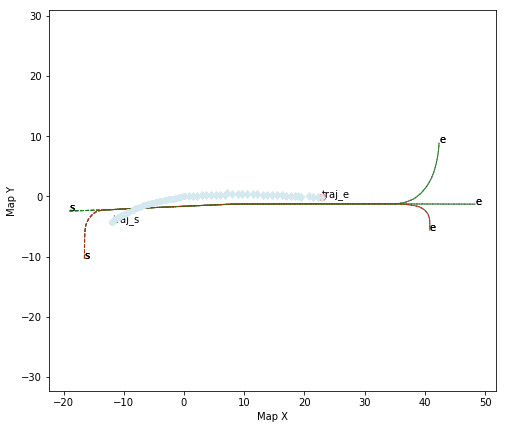

{'city': 'PIT',
 'trajs': [array([[3214.43285054, 1643.54545414],
         [3213.77555082, 1643.63429701],
         [3213.18515262, 1643.77824766],
         [3212.60236495, 1643.96554028],
         [3212.06111401, 1644.18592988],
         [3211.44373824, 1644.40458501],
         [3210.6284075 , 1644.6531432 ],
         [3210.07944796, 1644.91291055],
         [3209.53054128, 1645.20022963],
         [3208.85252034, 1645.57470415],
         [3208.25475978, 1645.95930412],
         [3207.66989349, 1646.3206023 ],
         [3207.06396634, 1646.71337946],
         [3206.53378795, 1647.13266205],
         [3205.91794318, 1647.54267514],
         [3205.30237808, 1647.97976618],
         [3204.86870057, 1648.33646003],
         [3204.33634243, 1648.58657101],
         [3203.85255334, 1649.04109062],
         [3203.27529717, 1649.44643146],
         [3202.72194048, 1650.04702387],
         [3202.22292343, 1650.53185245],
         [3201.69491933, 1651.01684529],
         [3201.12767532, 1651.55

In [105]:
# test data  
seq_path = f'../../TNT-Trajectory-Prediction/train/train/data/2.csv' 
test_data = ArgoProcess.loader.get(seq_path).seq_df

data = ArgoProcess.read_argo_data(test_data)  
ArgoProcess.get_obj_feats(data)

In [77]:
step_obs = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]  
step_obs = [0,1,2,3,4,10,11,12,13,14,15,16,17,19] 
obs_horizon = 20 
for i in range(len(step_obs)): 
    print(step_obs[i]) 
    print(obs_horizon - len(step_obs) + i)
    if step_obs[i] == obs_horizon - len(step_obs) + i:
        break 
    
step_obs = step_obs[i:]
# traj_obs = traj_obs[i:]
      

0
6
1
7
2
8
3
9
4
10
10
11
11
12
12
13
13
14
14
15
15
16
16
17
17
18
19
19


In [71]:
step_obs

[19]